In [2]:
"""
Importation of modules required for project
"""
# Modules for production of diagrams and graphs
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import os

# Modules required for image loading, preprocessing and augmentation
from cv2 import imread, resize, normalize, INTER_LINEAR, NORM_MINMAX
from keras.layers import RandomTranslation, RandomContrast, RandomRotation

# Libraries for machine learning model training and evaluation
import numpy as np
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.models import load_model

# Module required for performance evaluation metrics
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report

# Specify starting point for random number sequence generation
np.random.seed(0)

In [3]:
"""
Functions required for training the models
"""

# Neccessary initial value
class_list = []

def filter_dataset(file_directory='dataset/',
                unknown_path='dataset/unknown',
                smoke_path = 'dataset/smoke',
                mininum_images = 458,
                verbose = 0):
    """
    This function returns lists that will be used to store the names
    of the classes to be used in training, the paths to images for 
    each class, and the highest number of images out of all classes.

    The image path is only recorded if the number of images in the class
    exceeds the minimum_images integer

    Arguments
        ---------
        file_directory : String
            Directory of dataset containing images where each folder
            in 'dataset/' is a different class

        unknown_path : String
            Directory of unknown class path

        smoke_path : String
            Directory of smoke class path

        mininum_images : Integer
            Minimum number of images a class must have to be stored
            in paths_to_classes list

        verbose : String
            The amount of print statements the functions generates.
            Can be either 0, 1 or 2. Each number increases the 
            amount of information

        Example
        -------
        >>> paths_to_classes, class_list = filter_dataset(verbose=1)
        >>> Total number of filtered classes: 5
        >>> Class list:
	            ['unknown', '1_1', '1_11_1', '1_11_2', '7_7']
        >>> Highest amount of images per class: 600
    """
    # List containing paths to images
    paths_to_classes = list()

    # List containing class names
    class_list = []

    # Records the highest number of images out of all the classes
    max_counter = 0

    # Traverse the dataset directory, counting the number of images
    # per class (as folder).
    # If image_count is greater than minimum_images, add this path,
    # and class name to our lists (paths_to_classes and class_list)
    for (dirpath, dirnames, filenames) in os.walk(file_directory):
        image_count = 0

        # Count images
        for image in os.listdir(dirpath):
            image_count += 1
        
        # Keep track of the highest number of images out of all the classes
        max_counter = max(image_count, max_counter)
        
        # Appened to lists, making sure we are not including the parent
        # directory (file_directory)
        if image_count >= mininum_images and dirpath != file_directory:
            if verbose > 1:
                print(dirpath, "number of files", image_count)
            paths_to_classes.append(dirpath)
            class_list.append(dirpath.replace('dataset/', ''))

    # Sort classes for reproducibility
    paths_to_classes.sort()
    class_list.sort()

    # Remove smoke class, we only want traffic signs
    paths_to_classes.remove(smoke_path)
    class_list.remove(smoke_path.replace('dataset/', ''))

    # Push unknown class to front of list (this ensures it is always in train set)
    paths_to_classes.remove(unknown_path)
    paths_to_classes.insert(0, unknown_path)
    class_list.remove(unknown_path.replace('dataset/', ''))
    class_list.insert(0, unknown_path.replace('dataset/', ''))

    if verbose > 0 :
        print("\nTotal number of filtered classes:", len(paths_to_classes))
        print("Class list:\n\t",class_list)
        print("Highest amount of images per class:", max_counter)

    return paths_to_classes, class_list, max_counter


def class_label_encoder(raw_labels,
        num_of_classes,
        class_names=class_list):
    """
    This function takes raw class labels and returns an array
    of one hot encoded vectors

    Arguments
            ---------
            raw_labels : List
                List containing raw unencoded labels

            num_of_classes : Integer
                Total number of classes 

            class_names : List
                List of class names

            Example
            -------
            >>> class_label_encoder(np.array(class_label_raw))
    """
    encoded_classes = []
    t = class_names.copy()
    for row, label in enumerate(raw_labels):
        temp_row = np.zeros((1, num_of_classes), dtype="int")
        i = t.index(label)
        temp_row[0,i] = 1
        encoded_classes.append(temp_row)
    return np.array(encoded_classes).reshape(-1, num_of_classes)


def process_image(img_path, size=(64,64)):
    """
    This function returns prepocessed images by 
    contrast normalizing and resizing them to 64x64

    Arguments
            ---------
            img_path : String
                Path to the image

            size : Tuple
                Tuple containing the size to resize
                images to

            Example
            -------
            >>> process_image('dataset/1_1/img1.jpg)
    """
    # Load image
    img = resize(imread(img_path), size, interpolation = INTER_LINEAR)
    norm_img = np.zeros(size) 
    final = normalize(img, norm_img, 0, 255, norm_type=NORM_MINMAX)
    return final


# Define Keras data augmentation layers
data_augmentation = Sequential([
    RandomTranslation(
        height_factor=0.1,
        width_factor=0.1,
        fill_mode="wrap"),
    RandomContrast(0.2),
    RandomRotation(factor=1)
])


def create_dataset(
        num_of_classes=len(class_list),
        path='dataset/',
        class_names=class_list,
        augmentThresh=600):
    """
    This function creates the dataset to be used for training, it
    returns a numpy array of preprocessed images and their encoded labels

    Arguments
            ---------
            num_of_classes : Integer
                Number of classes from class_names to be used to
                create the dataset. This 'unknown' class is always
                added to this number. Therefore passing 19, will result
                in a dataset with 20 classes.

            path : String
                Path to raw dataset
            
            class_names : List
                List of class names

            augmentThresh : Integer
                This determines the minimum number of images all 
                classes must contain, if a class does not contain 
                augmentThresh many images, data augmentation will be used to
                fill in the gap

            Example
            -------
            >>> imgList, class_label = create_dataset(19)
    """
    # List containing our images (X_train/X_test, features)
    imgList = []

    # List containing the unencoded class labels (y_train/y_test, labels)
    class_label_raw = []

    # Add 1 to account for the 'unknown' class
    num_of_classes += 1 

    # Being creating dataset    
    for image_class in paths_to_classes:

        # Keep track of how many images we need to augment
        remaining = augmentThresh - len(os.listdir(image_class))

        # Traverse through all class folders
        for imgName in os.listdir(image_class): 
            label = image_class.replace(path, '')

            # We only take the first num_of_classes classes
            if label not in class_names[:num_of_classes]: 
                break
            
            # Preprocess image before appending to lists
            imgList.append(process_image(
                os.path.join(image_class,imgName)))
            class_label_raw.append(label) 
            
            # If amount of images in class is less than augmentThresh
            # Augment the required amount of images
            if remaining > 0:
                class_label_raw.append(label)
                augment = data_augmentation(
                    process_image(os.path.join(image_class,imgName)))
                imgList.append(augment)
                remaining -= 1

    # Convert to numpy arrays and return dataset
    return np.array(imgList), class_label_encoder(
                                np.array(class_label_raw),
                                num_of_classes=num_of_classes,
                                class_names=class_names)


def create_dataset_restricted(
        num_of_classes=len(class_list),
        srcMin = 70,
        augmentFactor = 15,
        path='dataset/',
        class_names=class_list):
    """
    This function creates a dataset with the amount of images restricted to srcMin. 
    It will augment images by a factor of augmentFactor.
    This function is used to determine the minimum number of images required
    to train a model with good performance (over 90% accuracy on test set)

    Arguments
            ---------
            num_of_classes : Integer
                Number of classes from class_names to be used to
                create the dataset. This 'unknown' class is always
                added to this number. Therefore passing 19, will result
                in a dataset with 20 classes.

            path : String
                Path to raw dataset
            
            class_names : List
                List of class names

            augmentThresh : Integer
                This determines the minimum number of images all 
                classes must contain, if a class does not contain 
                augmentThresh many images, data augmentation will be used to
                fill in the gap

            Example
            -------
            >>> imgList, class_label = create_dataset(19)
    """
    # List containing our images (X_train/X_test, features)
    imgList = []

    # List containing the unencoded class labels (y_train/y_test, labels)
    class_label_raw = []

    # Add 1 to account for the 'unknown' class
    num_of_classes += 1 

    # Being creating dataset    
    for image_class in paths_to_classes:

        # Keep track of how many images we have loaded
        srcCount = 0

        # Traverse through all class folders
        for imgName in os.listdir(image_class): 
            label = image_class.replace(path, '')

            # We only take the first num_of_classes classes
            if label not in class_names[:num_of_classes]: 
                break
            
            # Preprocess image before appending to lists
            imgList.append(process_image(
                os.path.join(image_class,imgName)))
            class_label_raw.append(label) 
            
            # Augment dataset by a factor of augmentFactor
            for i in range(augmentFactor-1):
                class_label_raw.append(label)
                augment = data_augmentation(process_image(
                    os.path.join(path,imgName)))
                imgList.append(augment)

            # Update srcCount    
            srcCount += 1

    # Convert to numpy arrays and return dataset
    return np.array(imgList), class_label_encoder(
                                np.array(class_label_raw),
                                num_of_classes=num_of_classes,
                                class_names=class_names)


def train_cnn(
    X_train,
    y_train,
    num_of_classes,
    epochs=10,
    batch_size=16,
    k_folds=5):
    """
    This function returns a list of k-fold cross validated CNN models.

    Arguments
            ---------
            X_train : np.ndarray 
                Numpy array containing features (X)
            
            y_train : np.ndarray
                Numpy array containing one hot 
                vector encoded class labels (y)

            num_of_classes: Integer
                Number of classes the model is trained on
            
            epochs : Integer
                Number of epochs to train

            batch_size : Integer
                Size of mini-batches
            
            k_folds : Integer
                Number of folds to use for cross validation

            Example
            -------
            >>> models = train_cnn(X_train, y_train, 19)
    """
    # Defines the hidden neruons and pool size
    hidden_num_units = 2048
    hidden_num_units1 = 1024
    hidden_num_units2 = 128
    pool_size = (2, 2)

    # Add one to the number of classes to account 
    # for unknown class always being added
    output_num_units = num_of_classes + 1

    # We test the model for each fold
    KFolds = KFold(n_splits=k_folds)

    # List to store model after each fold
    models = []

    # Begin training loop
    for train_fold, test_fold in KFolds.split(X_train):

        model = Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=(64,64,3), 
                    padding='same'),
        BatchNormalization(),

        Conv2D(16, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.2),
            
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
            
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.2),
            
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
            
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=pool_size),
        Dropout(0.2),

        Flatten(),

        Dense(units=hidden_num_units, activation='relu'),
        Dropout(0.3),
        Dense(units=hidden_num_units1, activation='relu'),
        Dropout(0.3),
        Dense(units=hidden_num_units2, activation='relu'),
        Dropout(0.3),
        Dense(units=output_num_units,
            input_dim=hidden_num_units, 
            activation='softmax')
        ])

        # Compile the model
        model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=1e-4),
            metrics=['accuracy'])

        # Train model
        model.fit(
            X_train[train_fold],
            y_train[train_fold],
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_train[test_fold],
            y_train[test_fold]))
        
        # Add model to models list
        models.append(model)

    return models


def get_best_model(models):
    """
    This function returns the best model in a list of models
    generated from a cross validation training loop. It also
    returns a list of stats including the best accuracy,
    standard deviation of the accuracy and average accuracy. 

    Arguments
            ---------
            models : List of Keras models 
                List of models to compare

            Example
            -------
            >>> model, cross_val_stats = get_best_model(models)
    """
    best_acc = 0.00
    best_model = models[0]
    acc_list = []

    # Iterate through models and calcuate
    # accuracy stats
    for i in range(len(models)):
        acc = np.max(models[i].history.history['val_accuracy'])
        if best_acc < acc:
            best_model = models[i]
        acc_list.append(acc)
    acc_std = np.std(acc_list)
    acc_avg = np.average(acc_list)

    return best_model, [best_acc, acc_std, acc_avg]

# Setup the dataset
paths_to_classes, class_list, max_counter = filter_dataset(verbose=1)


Total number of filtered classes: 86
Class list:
	 ['unknown', '1_1', '1_11_1', '1_11_2', '1_12_1', '1_12_2', '1_13', '1_14', '1_15', '1_16', '1_17', '1_2', '1_20_1', '1_20_2', '1_20_3', '1_22', '1_23', '1_26', '1_27', '1_33', '1_5', '1_7', '1_8', '2_1', '2_2', '2_3_1', '2_3_L', '2_3_R', '2_4', '2_5', '3_1', '3_15', '3_16', '3_18_1', '3_18_2', '3_2', '3_20', '3_21', '3_27', '3_28', '3_29', '3_30', '3_31', '3_32', '3_33', '3_5', '4_1_1', '4_1_2', '4_1_2_1', '4_1_3', '4_1_3_1', '4_1_4', '4_1_5', '4_2_1', '4_2_2', '4_2_3', '4_3', '4_4_1', '4_5_4', '5_14', '5_14_2', '5_15_2+1', '5_15_2+2', '5_15_3', '5_15_5', '5_16', '5_19', '5_20', '5_21', '5_3', '5_5', '5_6', '6_16', '6_3_1', '6_4', '6_6', '6_7', '7_1', '7_11', '7_12', '7_14', '7_2', '7_3', '7_4', '7_5', '7_7']
Highest amount of images per class: 600


Image list shape: (12000, 64, 64, 3)
Test data shape: (3600, 64, 64, 3)


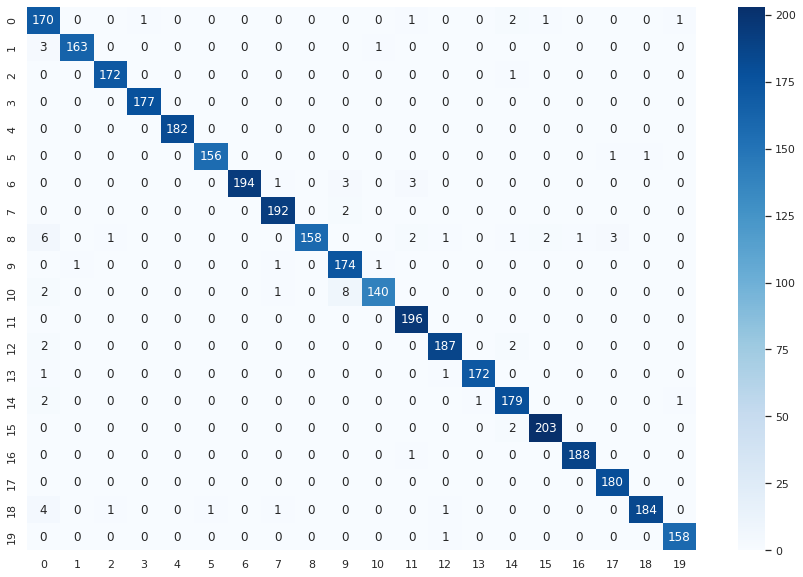

,precision,recall,f1-score,support
unknown,0.894737,0.965909,0.928962,176.000000
1_1,0.993902,0.976048,0.984894,167.000000
1_11_1,0.988506,0.994220,0.991354,173.000000
1_11_2,0.994382,1.000000,0.997183,177.000000
1_12_1,1.000000,1.000000,1.000000,182.000000
1_12_2,0.993631,0.987342,0.990476,158.000000
1_13,1.000000,0.965174,0.982278,201.000000
1_14,0.979592,0.989691,0.984615,194.000000
1_15,1.000000,0.902857,0.948949,175.000000
1_16,0.930481,0.983051,0.956044,177.000000


In [ ]:
"""
Train and evaluate our 20-Class Model
"""
# Define number of classes (without inclduing unknown class)
class_num = 19

# Create the 20-Class dataset
imgList_20, class_label_20 = create_dataset(num_of_classes=class_num, class_names=class_list)
print("Image list shape:", imgList_20.shape)

# Split the dataset into train and test, 
# set random state to 0 for reproducibility
X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(
    imgList_20, class_label_20, train_size=0.7, random_state=0)

# Delete unnecessary variables to save memory
del imgList_20
del class_label_20

# Comment these lines if you are training the model yourself
del X_train_20
del y_train_20

print("Test data shape:", X_test_20.shape)

# Uncomment the lines below, if you'd like to train
# the model yourself. If not, we have the previously
# trained model saved and loaded by default

# Train model
# models = train_cnn(X_train, y_train, class_num)

# Select best model and get stats
# model_20, stats = get_best_model(models)

# Load previously trained model (trained on Google Colab)
model_20 = load_model('models/20ClassModel/')

# Display classification report and confusion matrix
y_pred = np.argmax((model_20.predict(X_test_20)), axis=1)
y_true = np.argmax(y_test_20, axis=1)
rep = classification_report(y_true, y_pred, target_names=class_list[0:class_num+1], output_dict=True)
mt = confusion_matrix(y_true, y_pred)

# Clean up memory
del y_pred
del y_true

df_cm = pd.DataFrame(mt, range(20), range(20))
plt.figure(figsize=(15,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
plt.show()

pd.DataFrame(rep).T

Image list shape: (24000, 64, 64, 3)
Test data shape: (7200, 64, 64, 3)


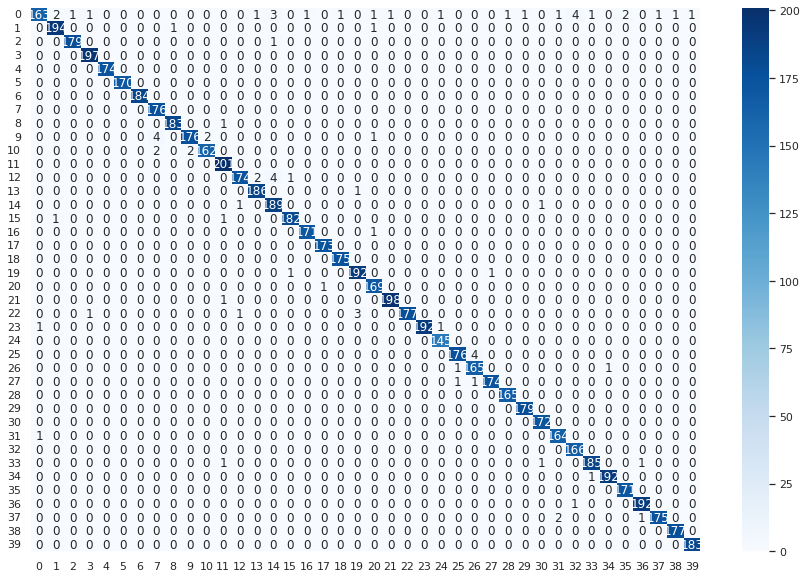

,precision,recall,f1-score,support
unknown,0.987879,0.862434,0.920904,189.000000
1_1,0.984772,0.989796,0.987277,196.000000
1_11_1,0.994444,0.994444,0.994444,180.000000
1_11_2,0.989950,1.000000,0.994949,197.000000
1_12_1,1.000000,1.000000,1.000000,174.000000
1_12_2,1.000000,1.000000,1.000000,170.000000
1_13,1.000000,1.000000,1.000000,184.000000
1_14,0.967033,1.000000,0.983240,176.000000
1_15,0.994565,0.994565,0.994565,184.000000
1_16,0.988764,0.961749,0.975069,183.000000


In [ ]:
"""
Train and evaluate our 40-Class Model
"""
# Define number of classes (without inclduing unknown class)
class_num = 39

# Create the 20-Class dataset
imgList_40, class_label_40 = create_dataset(num_of_classes=class_num, class_names=class_list)
print("Image list shape:", imgList_40.shape)

# Split the dataset into train and test, 
# set random state to 0 for reproducibility
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(
    imgList_40, class_label_40, train_size=0.7, random_state=0)

# Delete unnecessary variables to save memory
del imgList_40
del class_label_40

# Comment these lines if you are training the model yourself
del X_train_40
del y_train_40

print("Test data shape:", X_test_40.shape)

# Uncomment the lines below, if you'd like to train
# the model yourself. If not, we have the previously
# trained model saved and loaded by default

# Train model
# models = train_cnn(X_train, y_train, class_num)

# Select best model and get stats
# model_40, stats = get_best_model(models)

# Load previously trained model (trained on Google Colab)
model_40 = load_model('models/40ClassModel/')

# Display classification report and confusion matrix
y_pred = np.argmax((model_40.predict(X_test_40)), axis=1)
y_true = np.argmax(y_test_40, axis=1)
rep = classification_report(y_true, y_pred, target_names=class_list[0:class_num+1], output_dict=True)
mt = confusion_matrix(y_true, y_pred)

# Clean up memory
del y_pred
del y_true

df_cm = pd.DataFrame(mt, range(40), range(40))
plt.figure(figsize=(15,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
plt.show()

pd.DataFrame(rep).T

In [ ]:
"""
Train and evaluate our 20-Class Model (Trained on augmented images)
"""
# Define number of classes (without inclduing unknown class)
class_num = 19

# Create the 20-Class dataset
imgList_20_r, class_label_20_r = create_dataset_restricted(num_of_classes=class_num, class_names=class_list)
print("Image list shape:", imgList_20_r.shape)

# Split the dataset into train and test, 
# set random state to 0 for reproducibility
X_train_20_r, X_test_20_r, y_train_20_r, y_test_20_r = train_test_split(
    imgList_20_r, class_label_20_r, train_size=0.7, random_state=0)

# Delete unnecessary variables to save memory
del imgList_20_r
del class_label_20_r

# Comment these lines if you are training the model yourself
del X_train_20_r
del y_train_20_r

print("Test data shape:", X_test_20_r.shape)

# Uncomment the lines below, if you'd like to train
# the model yourself. If not, we have the previously
# trained model saved and loaded by default

# Train model
# models = train_cnn(X_train, y_train, class_num)

# Select best model and get stats
# model_20_r, stats = get_best_model(models)

# Load previously trained model (trained on Google Colab)
model_20_r = load_model('models/20ClassModel-70x15-Augmented/')

# Display classification report and confusion matrix
y_pred = np.argmax((model_20_r.predict(X_test_20_r)), axis=1)
y_true = np.argmax(y_test_20_r, axis=1)
rep = classification_report(y_true, y_pred, target_names=class_list[0:class_num+1], output_dict=True)
mt = confusion_matrix(y_true, y_pred)

# Clean up memory
del y_pred
del y_true

df_cm = pd.DataFrame(mt, range(40), range(40))
plt.figure(figsize=(15,10))
sn.set(font_scale=1)
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g')
plt.show()

pd.DataFrame(rep).T

Image number: 2607
Class label: 1_33
Model prediction: 1_33


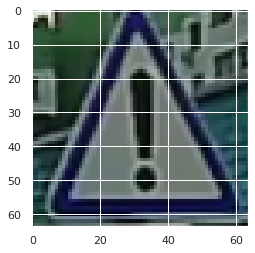

In [ ]:
def make_random_predictions(model, X_test, y_test):
    """
    This function makes predicitions from a random image
    in the test set and displays the image selected,
    the model's prediction and the actual image label

    Arguments
            ---------
            model : Keras model
                Model to use for prediction

            X_test : np.ndarray
                Numpy array containing test features (X)
            
            y_test : np.ndarray
                Numpy array containing test lables (y)

            Example
            -------
            >>> model, cross_val_stats = get_best_model(models)
    """
    index = np.random.choice(len(X_test))
    print("Image number:", index)
    plt.imshow(X_test[index].astype("uint8"))
    print("Class label:", class_list[np.argmax(y_test[index])])
    print("Model prediction:", class_list[np.argmax(model.predict(X_test[index].reshape(-1,64,64,3)).reshape(-1))])

make_random_predictions(model_40, X_test_40, y_test_40)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2deb0e42-6f7c-478a-84be-9db30111f064' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>